In [2]:
import warnings

warnings.filterwarnings("ignore")

import os
import gc
import pickle
import datetime
import joblib
import random
import ctypes
import math

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import holidays

In [3]:
!pip install --no-index -U --find-links=/kaggle/input/deeptables-dependecies deeptables==0.2.5

Looking in links: /kaggle/input/deeptables-dependecies
Processing /kaggle/input/deeptables-dependecies/deeptables-0.2.5-py3-none-any.whl
Processing /kaggle/input/deeptables-dependecies/hypernets-0.3.0-py3-none-any.whl (from deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/XlsxWriter-3.1.9-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/paramiko-3.3.1-py3-none-any.whl (from hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/bcrypt-4.0.1-cp36-abi3-manylinux_2_28_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)
Processing /kaggle/input/deeptables-dependecies/PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (from paramiko->hypernets>=0.2.5.1->deeptables==0.2.5)


In [4]:
import tensorflow as tf, deeptables as dt
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.python.keras import backend as K
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets

In [5]:
!pip install '/kaggle/input/polars-0-19-2/polars-0.19.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl'

Processing /kaggle/input/polars-0-19-2/polars-0.19.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Attempting uninstall: polars
    Found existing installation: polars 0.19.19
    Uninstalling polars-0.19.19:
      Successfully uninstalled polars-0.19.19


In [6]:
import polars as pl

In [7]:
%pip install -q wandb 
import wandb
wandb.login()

Note: you may need to restart the kernel to use updated packages.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
import traceback
import wandb
from wandb.keras import WandbCallback

In [9]:
seed = 1006
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed=seed)

def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)

clean_memory()

### Step 1 : Create a class to access and process all the data files

In [10]:
class DataStorage:
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
#         self.df_data = self.df_data.filter(
#             pl.col("datetime") >= pd.to_datetime("2022-01-01")
#         )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test

### Step 2: Create Feature Enegineering Classes

> <h4> For ease of understanding and clarity, I will be using two different feature engineering classes for both models. However, we can also merge them and make a single class since, most of the functions are the same with minor changes elsewhere. But remember to have two different <i>'generate_features'</i> functions for both of these in that case.

In [11]:
# diff
class FeaturesEngineer:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features
    
    # added some new features here
    def _additional_features(self,df):
        for col in [
                    'temperature', 
                    'dewpoint', 
                    '10_metre_u_wind_component', 
                    '10_metre_v_wind_component', 
            ]:
            for window in [1]:
                df[f"{col}_diff_{window}"] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business'])[col].diff(window)
        return df
    
    def _log_outliers(self,df):
        l1=['installed_capacity', 'target_mean', 'target_std']
        for i in l1:
            df = df.with_columns([(f"log_{i}", pl.when(df[i] != 0).then(np.log(pl.col(i))).otherwise(0))])
        return df

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
            #"date", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_holidays_features,
            self._log_outliers,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)
        df_features = self._additional_features(df_features)

        return df_features

In [12]:
# only
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [2 * 24,3 * 24,4 * 24,5 * 24,6 * 24,7 * 24,8 * 24,9 * 24,10 * 24,11 * 24,12 * 24,13 * 24,14 * 24,]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=["county","is_business","product_type","is_consumption","datetime",],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features
    
    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_holidays_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

# Initialisation

In [13]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)  # only
feat_gen = FeaturesEngineer(data_storage=data_storage)  # diff

In [14]:
# diff

df_train_features = feat_gen.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

if 'literal' in df_train_features.columns:
    df_train_features.drop(columns=['literal'],inplace=True)

In [15]:
# only

# df_train_feat = features_generator.generate_features(data_storage.df_data)
# df_train_feat = df_train_feat[df_train_feat['target'].notnull()]

# if 'literal' in df_train_feat.columns:
#     df_train_feat.drop(columns=['literal'],inplace=True)

# Model

Learning rate schedule: 1e-07 to 0.001 to 1e-07


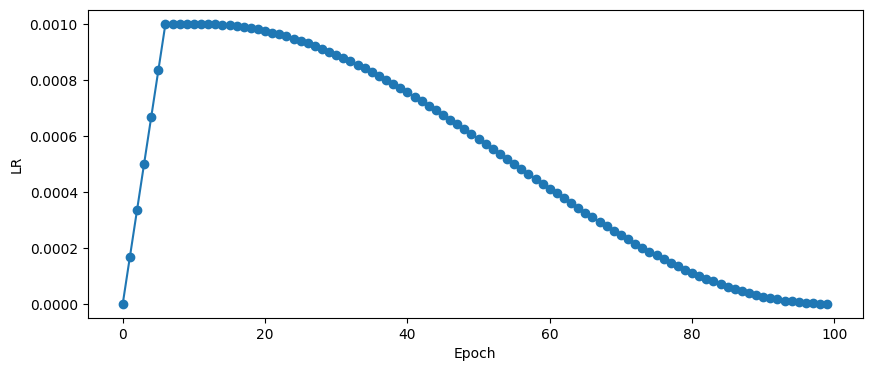

In [16]:
LR_START = 1e-7
LR_MAX = 1e-3
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 6
LR_SUSTAIN_EPOCHS = 5
EPOCHS = 100

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
        
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [33]:
class CFG:
    epochs_con = 100
    epochs_pro = 100
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = []  # [LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)
    # early stopping
    # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # save for the best
#     model_checkpoint_consumption = ModelCheckpoint(
#         filepath='best_nn_voting_regressor_consumption_model.h5', 
#         monitor='val_loss', 
#         save_best_only=True, 
#         verbose=1
#     )
#     model_checkpoint_production = ModelCheckpoint(
#         filepath='best_nn_voting_regressor_production_model.h5', 
#         monitor='val_loss', 
#         save_best_only=True, 
#         verbose=1
#     )

In [34]:
from tensorflow.keras.callbacks import Callback

class WandbLearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs={}):
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        wandb.log({"learning_rate": current_lr}, commit=False)

In [36]:
class ModelDiff:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns='auto',
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                    'hidden_units': ((512, 0.2, True),
                                                     (256, 0.2, True)),
                                    'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                                )
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)

    def fit(self, df_train_features):
        
#         callbacks_consumption = CFG.LR_Scheduler + [CFG.early_stopping, CFG.model_checkpoint_consumption]
#         callbacks_production = CFG.LR_Scheduler + [CFG.early_stopping, CFG.model_checkpoint_production]
#         callbacks_consumption = CFG.LR_Scheduler
#         callbacks_production = CFG.LR_Scheduler
        
        wandb.init(project="Enefit_DNN_consumption", entity="liuqy")
        
        wandb.config.update({
            "optimizer": CFG.optimizer,
            "batch_size": CFG.batch_size,
            "epochs_con": CFG.epochs_con,
            # add all other relevant configuration parameters here
        })
        
        callbacks_consumption = CFG.LR_Scheduler + [WandbCallback(), WandbLearningRateLogger()]
        
        with K.name_scope(CFG.optimizer.__class__.__name__):
            for i, var in enumerate(CFG.optimizer.weights):
                name = 'variable_con2{}'.format(i)
                CFG.optimizer.weights[i] = tf.Variable(var, name=name)
        self.conf = self.conf._replace(optimizer=CFG.optimizer)   
        self.nn_model_production = DeepTable(config=self.conf)
        
        print('\n',"nn model consumption training.",'\n')
        mask = df_train_features["is_consumption"] == 1
        X=df_train_features[mask].drop(columns=["target"])
        y=df_train_features[mask]["target"]
            - df_train_features[mask]["target_48h"].fillna(0)
        X_val = X[:-90]
        y_val = y[:-90]
        self.nn_model_consumption.fit(
            X=X,
            y=y,
            validation_data=[X_val, y_val],
            shuffle=False,
            batch_size=CFG.batch_size, 
            epochs=CFG.epochs_con, 
            verbose=2,
            callbacks=callbacks_consumption
        )
        
        #joblib.dump(self.nn_model_consumption, 'nn_voting_regressor_consumption_model.joblib')
        #self.nn_model_consumption.save('nn_voting_regressor_consumption_model.h5')
        wandb.finish()
        
        
        # is_production
        wandb.init(project="Enefit_DNN_production", entity="liuqy")

        wandb.config.update({
            "optimizer": CFG.optimizer,
            "batch_size": CFG.batch_size,
            "epochs_pro": CFG.epochs_pro,
            # add all other relevant configuration parameters here
        })
        callbacks_production = CFG.LR_Scheduler + [WandbCallback(), WandbLearningRateLogger()]

        # Avoid saving error
        with K.name_scope(CFG.optimizer.__class__.__name__):
            for i, var in enumerate(CFG.optimizer.weights):
                name = 'variable_pro2{}'.format(i)
                CFG.optimizer.weights[i] = tf.Variable(var, name=name)
        self.conf = self.conf._replace(optimizer=CFG.optimizer)   
        self.nn_model_production = DeepTable(config=self.conf)

        print('\n',"nn model production training.",'\n')
        mask = df_train_features["is_consumption"] == 0
        X=df_train_features[mask].drop(columns=["target"])
        y=df_train_features[mask]["target"]
            - df_train_features[mask]["target_48h"].fillna(0)
        X_val = X[:-90]
        y_val = y[:-90]
        
        self.nn_model_production.fit(
            X=X,
            y=y,
            validation_data=[X_val, y_val],
            shuffle=False,
            batch_size=CFG.batch_size, 
            epochs=CFG.epochs_pro, 
            verbose=2,
            callbacks=callbacks_production
        )
        
        wandb.finish()
        
        #joblib.dump(self.nn_model_production, 'nn_voting_regressor_production_model.joblib')
        #self.nn_model_production.save('nn_voting_regressor_production_model.h5')
        
#     def plot_nn_model(self):
#         return plot_model(self.nn_model_consumption.get_model().model)    

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
            
        print('\n',"nn model consumption prediction.",'\n')
        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(
            df_features[mask]["target_48h"].fillna(0).values
            + self.nn_model_consumption.predict(df_features[mask])[:,0],
            0,
            np.inf,
        )

        print('\n',"nn model production prediction.",'\n')
        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(
            df_features[mask]["target_48h"].fillna(0).values
            + self.nn_model_production.predict(df_features[mask])[:,0],
            0,
            np.inf,
        )
            
        return predictions

In [37]:
import atexit
atexit.register(wandb.finish)

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

In [38]:
model_diff = ModelDiff()
model_diff.fit(df_train_features)
clean_memory()

epoch,▁▂▃▅▆▇█
learning_rate,▁▁▁▁▁▁▁
loss,█▄▃▂▂▂▁
mean_absolute_error,█▄▃▂▂▂▁
val_loss,█▆▄▃▂▁▁
val_mean_absolute_error,█▆▄▃▂▁▁
best_epoch,6
best_val_loss,40.377
epoch,6
learning_rate,0.001
loss,47.08082



 nn model consumption training. 

01-23 03:07:03 I deeptables.m.deeptable.py 338 - X.Shape=(1008912, 169), y.Shape=(1008912,), batch_size=512, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics='MeanAbsoluteError', auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=False, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=False, apply_class_weight=False, optimizer=<tensorflow_addons.optimizers.weight_decay_optimizers.AdamW object at 0x7f463fe3d4b0>, loss='MeanAbsoluteError', dnn_params={'hidden_units': ((512, 0.2, True), (256, 0.2, True)), 'dnn_activat

01-23 03:07:05 W hypernets.t.cache.py 200 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-23 03:07:06 I deeptables.m.preprocessor.py 261 - Preparing features...
01-23 03:07:08 I deeptables.m.preprocessor.py 336 - Preparing features taken 2.1476359367370605s
01-23 03:07:08 I deeptables.m.preprocessor.py 341 - Data imputation...
01-23 03:07:15 I deeptables.m.preprocessor.py 383 - Imputation taken 6.959531545639038s
01-23 03:07:15 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-23 03:07:15 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.25136899948120117s
01-23 03:07:15 I deeptables.m.preprocessor.py 398 - Data discretization...
01-23 03:07:15 I hypernets.t.sklearn_ex.py 716 - 163 variables to discrete.
01-23 03:07:24 I deeptables.m.preprocessor.py 404 - Discretization taken 8.993224620819092s
01-23 03:07:27 I deeptables.m.preprocessor.py 196 - fit_transform taken 21.794931411743164s
01-23 03:07:27 I deeptables.m.deeptable.py 354 - Training...
01-23 03:07:27 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 111s - loss: 71.7174 - mean_absolute_error: 71.7174 - val_loss: 51.0597 - val_mean_absolute_error: 51.0597 - 111s/epoch - 59ms/step
Epoch 2/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.0s


1872/1872 - 84s - loss: 55.8514 - mean_absolute_error: 55.8514 - val_loss: 46.1307 - val_mean_absolute_error: 46.1307 - 84s/epoch - 45ms/step
Epoch 3/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 82s - loss: 52.5234 - mean_absolute_error: 52.5234 - val_loss: 43.3201 - val_mean_absolute_error: 43.3201 - 82s/epoch - 44ms/step
Epoch 4/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 82s - loss: 50.2368 - mean_absolute_error: 50.2368 - val_loss: 42.4755 - val_mean_absolute_error: 42.4755 - 82s/epoch - 44ms/step
Epoch 5/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 48.3836 - mean_absolute_error: 48.3836 - val_loss: 40.7625 - val_mean_absolute_error: 40.7625 - 81s/epoch - 43ms/step
Epoch 6/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 46.8418 - mean_absolute_error: 46.8418 - val_loss: 39.5003 - val_mean_absolute_error: 39.5003 - 80s/epoch - 43ms/step
Epoch 7/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 83s - loss: 45.5228 - mean_absolute_error: 45.5228 - val_loss: 38.9104 - val_mean_absolute_error: 38.9104 - 83s/epoch - 44ms/step
Epoch 8/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.0s


1872/1872 - 81s - loss: 44.3514 - mean_absolute_error: 44.3514 - val_loss: 38.2624 - val_mean_absolute_error: 38.2624 - 81s/epoch - 43ms/step
Epoch 9/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 43.3932 - mean_absolute_error: 43.3932 - val_loss: 36.9885 - val_mean_absolute_error: 36.9885 - 81s/epoch - 43ms/step
Epoch 10/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 82s - loss: 42.4537 - mean_absolute_error: 42.4537 - val_loss: 36.6337 - val_mean_absolute_error: 36.6337 - 82s/epoch - 44ms/step
Epoch 11/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 41.8170 - mean_absolute_error: 41.8170 - val_loss: 36.4285 - val_mean_absolute_error: 36.4285 - 81s/epoch - 43ms/step
Epoch 12/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 41.1661 - mean_absolute_error: 41.1661 - val_loss: 36.1249 - val_mean_absolute_error: 36.1249 - 81s/epoch - 43ms/step
Epoch 13/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 40.5108 - mean_absolute_error: 40.5108 - val_loss: 35.3153 - val_mean_absolute_error: 35.3153 - 80s/epoch - 43ms/step
Epoch 14/100
1872/1872 - 48s - loss: 39.9607 - mean_absolute_error: 39.9607 - val_loss: 35.3830 - val_mean_absolute_error: 35.3830 - 48s/epoch - 26ms/step
Epoch 15/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 39.4944 - mean_absolute_error: 39.4944 - val_loss: 34.5163 - val_mean_absolute_error: 34.5163 - 80s/epoch - 43ms/step
Epoch 16/100
1872/1872 - 48s - loss: 39.1235 - mean_absolute_error: 39.1235 - val_loss: 34.7030 - val_mean_absolute_error: 34.7030 - 48s/epoch - 26ms/step
Epoch 17/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 85s - loss: 38.7657 - mean_absolute_error: 38.7657 - val_loss: 34.0491 - val_mean_absolute_error: 34.0491 - 85s/epoch - 45ms/step
Epoch 18/100
1872/1872 - 53s - loss: 38.4237 - mean_absolute_error: 38.4237 - val_loss: 34.4023 - val_mean_absolute_error: 34.4023 - 53s/epoch - 28ms/step
Epoch 19/100
1872/1872 - 53s - loss: 38.0798 - mean_absolute_error: 38.0798 - val_loss: 34.2834 - val_mean_absolute_error: 34.2834 - 53s/epoch - 28ms/step
Epoch 20/100
1872/1872 - 48s - loss: 37.7101 - mean_absolute_error: 37.7101 - val_loss: 34.2613 - val_mean_absolute_error: 34.2613 - 48s/epoch - 25ms/step
Epoch 21/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 37.4025 - mean_absolute_error: 37.4025 - val_loss: 33.5683 - val_mean_absolute_error: 33.5683 - 81s/epoch - 43ms/step
Epoch 22/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 37.1092 - mean_absolute_error: 37.1092 - val_loss: 33.3221 - val_mean_absolute_error: 33.3221 - 80s/epoch - 43ms/step
Epoch 23/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 36.9829 - mean_absolute_error: 36.9829 - val_loss: 32.9414 - val_mean_absolute_error: 32.9414 - 81s/epoch - 43ms/step
Epoch 24/100
1872/1872 - 47s - loss: 36.7828 - mean_absolute_error: 36.7828 - val_loss: 33.0321 - val_mean_absolute_error: 33.0321 - 47s/epoch - 25ms/step
Epoch 25/100
1872/1872 - 47s - loss: 36.5356 - mean_absolute_error: 36.5356 - val_loss: 32.9513 - val_mean_absolute_error: 32.9513 - 47s/epoch - 25ms/step
Epoch 26/100
1872/1872 - 47s - loss: 36.2575 - mean_absolute_error: 36.2575 - val_loss: 33.2883 - val_mean_absolute_error: 33.2883 - 47s/epoch - 25ms/step
Epoch 27/100
1872/1872 - 47s - loss: 36.1117 - mean_absolute_error: 36.1117 - val_loss: 33.0456 - val_mean_absolute_error: 33.0456 - 47s/epoch - 25ms/step
Epoch 28/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 79s - loss: 35.8664 - mean_absolute_error: 35.8664 - val_loss: 32.5823 - val_mean_absolute_error: 32.5823 - 79s/epoch - 42ms/step
Epoch 29/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 35.6239 - mean_absolute_error: 35.6239 - val_loss: 32.3846 - val_mean_absolute_error: 32.3846 - 80s/epoch - 43ms/step
Epoch 30/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 35.4716 - mean_absolute_error: 35.4716 - val_loss: 32.3089 - val_mean_absolute_error: 32.3089 - 80s/epoch - 43ms/step
Epoch 31/100
1872/1872 - 47s - loss: 35.3231 - mean_absolute_error: 35.3231 - val_loss: 32.6262 - val_mean_absolute_error: 32.6262 - 47s/epoch - 25ms/step
Epoch 32/100
1872/1872 - 47s - loss: 35.1751 - mean_absolute_error: 35.1751 - val_loss: 32.5385 - val_mean_absolute_error: 32.5385 - 47s/epoch - 25ms/step
Epoch 33/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 79s - loss: 35.0243 - mean_absolute_error: 35.0243 - val_loss: 32.2957 - val_mean_absolute_error: 32.2957 - 79s/epoch - 42ms/step
Epoch 34/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 34.8986 - mean_absolute_error: 34.8986 - val_loss: 32.2052 - val_mean_absolute_error: 32.2052 - 80s/epoch - 43ms/step
Epoch 35/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 34.8434 - mean_absolute_error: 34.8434 - val_loss: 32.0584 - val_mean_absolute_error: 32.0584 - 80s/epoch - 43ms/step
Epoch 36/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 34.5642 - mean_absolute_error: 34.5642 - val_loss: 31.7805 - val_mean_absolute_error: 31.7805 - 80s/epoch - 43ms/step
Epoch 37/100
1872/1872 - 47s - loss: 34.4925 - mean_absolute_error: 34.4925 - val_loss: 32.1701 - val_mean_absolute_error: 32.1701 - 47s/epoch - 25ms/step
Epoch 38/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 79s - loss: 34.3481 - mean_absolute_error: 34.3481 - val_loss: 31.6335 - val_mean_absolute_error: 31.6335 - 79s/epoch - 42ms/step
Epoch 39/100
1872/1872 - 47s - loss: 34.2633 - mean_absolute_error: 34.2633 - val_loss: 31.7009 - val_mean_absolute_error: 31.7009 - 47s/epoch - 25ms/step
Epoch 40/100
1872/1872 - 47s - loss: 34.1686 - mean_absolute_error: 34.1686 - val_loss: 31.9274 - val_mean_absolute_error: 31.9274 - 47s/epoch - 25ms/step
Epoch 41/100
1872/1872 - 47s - loss: 34.0577 - mean_absolute_error: 34.0577 - val_loss: 32.3421 - val_mean_absolute_error: 32.3421 - 47s/epoch - 25ms/step
Epoch 42/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 33.9176 - mean_absolute_error: 33.9176 - val_loss: 31.6313 - val_mean_absolute_error: 31.6313 - 81s/epoch - 43ms/step
Epoch 43/100
1872/1872 - 48s - loss: 33.7373 - mean_absolute_error: 33.7373 - val_loss: 31.8939 - val_mean_absolute_error: 31.8939 - 48s/epoch - 25ms/step
Epoch 44/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 33.5407 - mean_absolute_error: 33.5407 - val_loss: 31.5709 - val_mean_absolute_error: 31.5709 - 81s/epoch - 43ms/step
Epoch 45/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 33.5938 - mean_absolute_error: 33.5938 - val_loss: 31.3675 - val_mean_absolute_error: 31.3675 - 80s/epoch - 43ms/step
Epoch 46/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 79s - loss: 33.5201 - mean_absolute_error: 33.5201 - val_loss: 30.8326 - val_mean_absolute_error: 30.8326 - 79s/epoch - 42ms/step
Epoch 47/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 80s - loss: 33.3508 - mean_absolute_error: 33.3508 - val_loss: 30.8280 - val_mean_absolute_error: 30.8280 - 80s/epoch - 43ms/step
Epoch 48/100
1872/1872 - 48s - loss: 33.2351 - mean_absolute_error: 33.2351 - val_loss: 31.0332 - val_mean_absolute_error: 31.0332 - 48s/epoch - 26ms/step
Epoch 49/100
1872/1872 - 48s - loss: 33.2046 - mean_absolute_error: 33.2046 - val_loss: 31.4609 - val_mean_absolute_error: 31.4609 - 48s/epoch - 25ms/step
Epoch 50/100
1872/1872 - 48s - loss: 33.2414 - mean_absolute_error: 33.2414 - val_loss: 31.1667 - val_mean_absolute_error: 31.1667 - 48s/epoch - 26ms/step
Epoch 51/100
1872/1872 - 48s - loss: 33.0747 - mean_absolute_error: 33.0747 - val_loss: 31.4041 - val_mean_absolute_error: 31.4041 - 48s/epoch - 25ms/step
Epoch 52/100
1872/1872 - 48s - loss: 32.9141 - mean_absolute_error: 32.9141 - val_loss: 31.1739 - val_mean_absolute_error: 31.1739 - 48s/epoch - 26ms/step
Epoch 53/100
1872/1872 - 45s - loss: 32.9379 - mean_absolute_error: 32.9379 - val_l

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 77s - loss: 32.8939 - mean_absolute_error: 32.8939 - val_loss: 30.7339 - val_mean_absolute_error: 30.7339 - 77s/epoch - 41ms/step
Epoch 55/100
1872/1872 - 44s - loss: 32.7448 - mean_absolute_error: 32.7448 - val_loss: 31.0148 - val_mean_absolute_error: 31.0148 - 44s/epoch - 24ms/step
Epoch 56/100
1872/1872 - 45s - loss: 32.6462 - mean_absolute_error: 32.6462 - val_loss: 31.1396 - val_mean_absolute_error: 31.1396 - 45s/epoch - 24ms/step
Epoch 57/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 75s - loss: 32.5976 - mean_absolute_error: 32.5976 - val_loss: 30.7264 - val_mean_absolute_error: 30.7264 - 75s/epoch - 40ms/step
Epoch 58/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 77s - loss: 32.4416 - mean_absolute_error: 32.4416 - val_loss: 30.6594 - val_mean_absolute_error: 30.6594 - 77s/epoch - 41ms/step
Epoch 59/100
1872/1872 - 44s - loss: 32.4879 - mean_absolute_error: 32.4879 - val_loss: 31.4640 - val_mean_absolute_error: 31.4640 - 44s/epoch - 24ms/step
Epoch 60/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 75s - loss: 32.4694 - mean_absolute_error: 32.4694 - val_loss: 30.6565 - val_mean_absolute_error: 30.6565 - 75s/epoch - 40ms/step
Epoch 61/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 76s - loss: 32.4176 - mean_absolute_error: 32.4176 - val_loss: 30.4981 - val_mean_absolute_error: 30.4981 - 76s/epoch - 40ms/step
Epoch 62/100
1872/1872 - 44s - loss: 32.3309 - mean_absolute_error: 32.3309 - val_loss: 31.1409 - val_mean_absolute_error: 31.1409 - 44s/epoch - 23ms/step
Epoch 63/100
1872/1872 - 44s - loss: 32.2945 - mean_absolute_error: 32.2945 - val_loss: 30.5752 - val_mean_absolute_error: 30.5752 - 44s/epoch - 24ms/step
Epoch 64/100
1872/1872 - 45s - loss: 32.2176 - mean_absolute_error: 32.2176 - val_loss: 30.7982 - val_mean_absolute_error: 30.7982 - 45s/epoch - 24ms/step
Epoch 65/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.0s


1872/1872 - 74s - loss: 32.1160 - mean_absolute_error: 32.1160 - val_loss: 30.0381 - val_mean_absolute_error: 30.0381 - 74s/epoch - 40ms/step
Epoch 66/100
1872/1872 - 43s - loss: 32.1126 - mean_absolute_error: 32.1126 - val_loss: 30.9228 - val_mean_absolute_error: 30.9228 - 43s/epoch - 23ms/step
Epoch 67/100
1872/1872 - 43s - loss: 32.0458 - mean_absolute_error: 32.0458 - val_loss: 30.6248 - val_mean_absolute_error: 30.6248 - 43s/epoch - 23ms/step
Epoch 68/100
1872/1872 - 43s - loss: 31.9384 - mean_absolute_error: 31.9384 - val_loss: 30.0952 - val_mean_absolute_error: 30.0952 - 43s/epoch - 23ms/step
Epoch 69/100
1872/1872 - 43s - loss: 31.9253 - mean_absolute_error: 31.9253 - val_loss: 30.2903 - val_mean_absolute_error: 30.2903 - 43s/epoch - 23ms/step
Epoch 70/100
1872/1872 - 42s - loss: 31.8991 - mean_absolute_error: 31.8991 - val_loss: 30.5157 - val_mean_absolute_error: 30.5157 - 42s/epoch - 23ms/step
Epoch 71/100
1872/1872 - 42s - loss: 31.7924 - mean_absolute_error: 31.7924 - val_l

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 77s - loss: 31.2489 - mean_absolute_error: 31.2489 - val_loss: 29.7889 - val_mean_absolute_error: 29.7889 - 77s/epoch - 41ms/step
Epoch 86/100
1872/1872 - 43s - loss: 31.1004 - mean_absolute_error: 31.1004 - val_loss: 30.0065 - val_mean_absolute_error: 30.0065 - 43s/epoch - 23ms/step
Epoch 87/100
1872/1872 - 43s - loss: 31.2365 - mean_absolute_error: 31.2365 - val_loss: 30.3259 - val_mean_absolute_error: 30.3259 - 43s/epoch - 23ms/step
Epoch 88/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_030603-5bu2h4ox/files/model-best)... Done. 0.1s


1872/1872 - 73s - loss: 31.1641 - mean_absolute_error: 31.1641 - val_loss: 29.5091 - val_mean_absolute_error: 29.5091 - 73s/epoch - 39ms/step
Epoch 89/100
1872/1872 - 43s - loss: 31.1619 - mean_absolute_error: 31.1619 - val_loss: 30.2974 - val_mean_absolute_error: 30.2974 - 43s/epoch - 23ms/step
Epoch 90/100
1872/1872 - 43s - loss: 31.0832 - mean_absolute_error: 31.0832 - val_loss: 29.8187 - val_mean_absolute_error: 29.8187 - 43s/epoch - 23ms/step
Epoch 91/100
1872/1872 - 42s - loss: 30.9783 - mean_absolute_error: 30.9783 - val_loss: 29.7552 - val_mean_absolute_error: 29.7552 - 42s/epoch - 23ms/step
Epoch 92/100
1872/1872 - 43s - loss: 31.0715 - mean_absolute_error: 31.0715 - val_loss: 30.0425 - val_mean_absolute_error: 30.0425 - 43s/epoch - 23ms/step
Epoch 93/100
1872/1872 - 43s - loss: 30.9428 - mean_absolute_error: 30.9428 - val_loss: 29.7824 - val_mean_absolute_error: 29.7824 - 43s/epoch - 23ms/step
Epoch 94/100
1872/1872 - 42s - loss: 30.9373 - mean_absolute_error: 30.9373 - val_l

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,87
best_val_loss,29.50909
epoch,99
learning_rate,0.001
loss,30.83429



 nn model production training. 

01-23 04:46:30 I deeptables.m.deeptable.py 338 - X.Shape=(1008912, 169), y.Shape=(1008912,), batch_size=512, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics='MeanAbsoluteError', auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=False, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=False, apply_class_weight=False, optimizer=<tensorflow_addons.optimizers.weight_decay_optimizers.AdamW object at 0x7f463fe3d4b0>, loss='MeanAbsoluteError', dnn_params={'hidden_units': ((512, 0.2, True), (256, 0.2, True)), 'dnn_activati

01-23 04:46:32 W hypernets.t.cache.py 200 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/opt/conda/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-23 04:46:32 I deeptables.m.preprocessor.py 261 - Preparing features...
01-23 04:46:34 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.6330902576446533s
01-23 04:46:34 I deeptables.m.preprocessor.py 341 - Data imputation...
01-23 04:46:41 I deeptables.m.preprocessor.py 383 - Imputation taken 6.871758699417114s
01-23 04:46:41 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-23 04:46:41 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.22920513153076172s
01-23 04:46:41 I deeptables.m.preprocessor.py 398 - Data discretization...
01-23 04:46:41 I hypernets.t.sklearn_ex.py 716 - 163 variables to discrete.
01-23 04:46:48 I deeptables.m.preprocessor.py 404 - Discretization taken 7.147434234619141s
01-23 04:46:51 I deeptables.m.preprocessor.py 196 - fit_transform taken 19.623297214508057s
01-23 04:46:51 I deeptables.m.deeptable.py 354 - Training...
01-23 04:46:51 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.0s


1872/1872 - 108s - loss: 28.5916 - mean_absolute_error: 28.5916 - val_loss: 22.9152 - val_mean_absolute_error: 22.9152 - 108s/epoch - 58ms/step
Epoch 2/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 77s - loss: 24.6021 - mean_absolute_error: 24.6021 - val_loss: 21.0029 - val_mean_absolute_error: 21.0029 - 77s/epoch - 41ms/step
Epoch 3/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 75s - loss: 22.9398 - mean_absolute_error: 22.9398 - val_loss: 19.0638 - val_mean_absolute_error: 19.0638 - 75s/epoch - 40ms/step
Epoch 4/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 76s - loss: 20.7137 - mean_absolute_error: 20.7137 - val_loss: 17.3676 - val_mean_absolute_error: 17.3676 - 76s/epoch - 41ms/step
Epoch 6/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 74s - loss: 19.9469 - mean_absolute_error: 19.9469 - val_loss: 16.7589 - val_mean_absolute_error: 16.7589 - 74s/epoch - 40ms/step
Epoch 7/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 74s - loss: 19.2494 - mean_absolute_error: 19.2494 - val_loss: 16.3973 - val_mean_absolute_error: 16.3973 - 74s/epoch - 40ms/step
Epoch 8/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 77s - loss: 18.7351 - mean_absolute_error: 18.7351 - val_loss: 16.3772 - val_mean_absolute_error: 16.3772 - 77s/epoch - 41ms/step
Epoch 9/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.0s


1872/1872 - 77s - loss: 18.2715 - mean_absolute_error: 18.2715 - val_loss: 16.1341 - val_mean_absolute_error: 16.1341 - 77s/epoch - 41ms/step
Epoch 10/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 74s - loss: 17.8755 - mean_absolute_error: 17.8755 - val_loss: 15.6201 - val_mean_absolute_error: 15.6201 - 74s/epoch - 39ms/step
Epoch 11/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 74s - loss: 17.5802 - mean_absolute_error: 17.5802 - val_loss: 15.4274 - val_mean_absolute_error: 15.4274 - 74s/epoch - 40ms/step
Epoch 12/100
1872/1872 - 43s - loss: 17.2091 - mean_absolute_error: 17.2091 - val_loss: 15.5449 - val_mean_absolute_error: 15.5449 - 43s/epoch - 23ms/step
Epoch 13/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 75s - loss: 16.9657 - mean_absolute_error: 16.9657 - val_loss: 14.9977 - val_mean_absolute_error: 14.9977 - 75s/epoch - 40ms/step
Epoch 14/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 75s - loss: 16.7361 - mean_absolute_error: 16.7361 - val_loss: 14.7028 - val_mean_absolute_error: 14.7028 - 75s/epoch - 40ms/step
Epoch 15/100
1872/1872 - 43s - loss: 16.4638 - mean_absolute_error: 16.4638 - val_loss: 14.8811 - val_mean_absolute_error: 14.8811 - 43s/epoch - 23ms/step
Epoch 16/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 75s - loss: 16.2969 - mean_absolute_error: 16.2969 - val_loss: 14.3008 - val_mean_absolute_error: 14.3008 - 75s/epoch - 40ms/step
Epoch 17/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 78s - loss: 16.0478 - mean_absolute_error: 16.0478 - val_loss: 14.1721 - val_mean_absolute_error: 14.1721 - 78s/epoch - 42ms/step
Epoch 18/100
1872/1872 - 49s - loss: 15.8547 - mean_absolute_error: 15.8547 - val_loss: 14.2339 - val_mean_absolute_error: 14.2339 - 49s/epoch - 26ms/step
Epoch 19/100
1872/1872 - 49s - loss: 15.7257 - mean_absolute_error: 15.7257 - val_loss: 14.2963 - val_mean_absolute_error: 14.2963 - 49s/epoch - 26ms/step
Epoch 20/100
1872/1872 - 49s - loss: 15.4870 - mean_absolute_error: 15.4870 - val_loss: 14.2246 - val_mean_absolute_error: 14.2246 - 49s/epoch - 26ms/step
Epoch 21/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 15.4151 - mean_absolute_error: 15.4151 - val_loss: 13.8939 - val_mean_absolute_error: 13.8939 - 81s/epoch - 43ms/step
Epoch 22/100
1872/1872 - 48s - loss: 15.2578 - mean_absolute_error: 15.2578 - val_loss: 14.2532 - val_mean_absolute_error: 14.2532 - 48s/epoch - 26ms/step
Epoch 23/100
1872/1872 - 48s - loss: 15.1025 - mean_absolute_error: 15.1025 - val_loss: 13.9359 - val_mean_absolute_error: 13.9359 - 48s/epoch - 25ms/step
Epoch 24/100
1872/1872 - 48s - loss: 14.9641 - mean_absolute_error: 14.9641 - val_loss: 14.0100 - val_mean_absolute_error: 14.0100 - 48s/epoch - 26ms/step
Epoch 25/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 14.9319 - mean_absolute_error: 14.9319 - val_loss: 13.7246 - val_mean_absolute_error: 13.7246 - 81s/epoch - 43ms/step
Epoch 26/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 82s - loss: 14.7865 - mean_absolute_error: 14.7865 - val_loss: 13.6846 - val_mean_absolute_error: 13.6846 - 82s/epoch - 44ms/step
Epoch 27/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 81s - loss: 14.7001 - mean_absolute_error: 14.7001 - val_loss: 13.2346 - val_mean_absolute_error: 13.2346 - 81s/epoch - 43ms/step
Epoch 28/100
1872/1872 - 43s - loss: 14.6223 - mean_absolute_error: 14.6223 - val_loss: 13.2882 - val_mean_absolute_error: 13.2882 - 43s/epoch - 23ms/step
Epoch 29/100
1872/1872 - 43s - loss: 14.5159 - mean_absolute_error: 14.5159 - val_loss: 13.2598 - val_mean_absolute_error: 13.2598 - 43s/epoch - 23ms/step
Epoch 30/100
1872/1872 - 42s - loss: 14.4140 - mean_absolute_error: 14.4140 - val_loss: 13.4818 - val_mean_absolute_error: 13.4818 - 42s/epoch - 23ms/step
Epoch 31/100
1872/1872 - 43s - loss: 14.3190 - mean_absolute_error: 14.3190 - val_loss: 13.3210 - val_mean_absolute_error: 13.3210 - 43s/epoch - 23ms/step
Epoch 32/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 74s - loss: 14.2451 - mean_absolute_error: 14.2451 - val_loss: 13.1617 - val_mean_absolute_error: 13.1617 - 74s/epoch - 40ms/step
Epoch 33/100
1872/1872 - 42s - loss: 14.1866 - mean_absolute_error: 14.1866 - val_loss: 13.4179 - val_mean_absolute_error: 13.4179 - 42s/epoch - 23ms/step
Epoch 34/100
1872/1872 - 43s - loss: 14.1199 - mean_absolute_error: 14.1199 - val_loss: 13.2648 - val_mean_absolute_error: 13.2648 - 43s/epoch - 23ms/step
Epoch 35/100
1872/1872 - 43s - loss: 14.0349 - mean_absolute_error: 14.0349 - val_loss: 13.2429 - val_mean_absolute_error: 13.2429 - 43s/epoch - 23ms/step
Epoch 36/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 77s - loss: 13.9542 - mean_absolute_error: 13.9542 - val_loss: 13.0855 - val_mean_absolute_error: 13.0855 - 77s/epoch - 41ms/step
Epoch 37/100
1872/1872 - 45s - loss: 13.9489 - mean_absolute_error: 13.9489 - val_loss: 13.4330 - val_mean_absolute_error: 13.4330 - 45s/epoch - 24ms/step
Epoch 38/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 79s - loss: 13.7686 - mean_absolute_error: 13.7686 - val_loss: 13.0789 - val_mean_absolute_error: 13.0789 - 79s/epoch - 42ms/step
Epoch 39/100
1872/1872 - 47s - loss: 13.8037 - mean_absolute_error: 13.8037 - val_loss: 13.1354 - val_mean_absolute_error: 13.1354 - 47s/epoch - 25ms/step
Epoch 40/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 76s - loss: 13.7023 - mean_absolute_error: 13.7023 - val_loss: 12.9769 - val_mean_absolute_error: 12.9769 - 76s/epoch - 41ms/step
Epoch 41/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 79s - loss: 13.6535 - mean_absolute_error: 13.6535 - val_loss: 12.6191 - val_mean_absolute_error: 12.6191 - 79s/epoch - 42ms/step
Epoch 42/100
1872/1872 - 47s - loss: 13.6311 - mean_absolute_error: 13.6311 - val_loss: 12.8520 - val_mean_absolute_error: 12.8520 - 47s/epoch - 25ms/step
Epoch 43/100
1872/1872 - 47s - loss: 13.5734 - mean_absolute_error: 13.5734 - val_loss: 12.6409 - val_mean_absolute_error: 12.6409 - 47s/epoch - 25ms/step
Epoch 44/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 79s - loss: 13.5168 - mean_absolute_error: 13.5168 - val_loss: 12.5128 - val_mean_absolute_error: 12.5128 - 79s/epoch - 42ms/step
Epoch 45/100
1872/1872 - 47s - loss: 13.4995 - mean_absolute_error: 13.4995 - val_loss: 12.7350 - val_mean_absolute_error: 12.7350 - 47s/epoch - 25ms/step
Epoch 46/100
1872/1872 - 47s - loss: 13.4232 - mean_absolute_error: 13.4232 - val_loss: 12.6867 - val_mean_absolute_error: 12.6867 - 47s/epoch - 25ms/step
Epoch 47/100
1872/1872 - 46s - loss: 13.3731 - mean_absolute_error: 13.3731 - val_loss: 12.7820 - val_mean_absolute_error: 12.7820 - 46s/epoch - 25ms/step
Epoch 48/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 79s - loss: 13.3200 - mean_absolute_error: 13.3200 - val_loss: 12.3724 - val_mean_absolute_error: 12.3724 - 79s/epoch - 42ms/step
Epoch 49/100
1872/1872 - 47s - loss: 13.3172 - mean_absolute_error: 13.3172 - val_loss: 12.8340 - val_mean_absolute_error: 12.8340 - 47s/epoch - 25ms/step
Epoch 50/100
1872/1872 - 43s - loss: 13.2066 - mean_absolute_error: 13.2066 - val_loss: 12.9358 - val_mean_absolute_error: 12.9358 - 43s/epoch - 23ms/step
Epoch 51/100
1872/1872 - 43s - loss: 13.1865 - mean_absolute_error: 13.1865 - val_loss: 12.5967 - val_mean_absolute_error: 12.5967 - 43s/epoch - 23ms/step
Epoch 52/100
1872/1872 - 43s - loss: 13.1720 - mean_absolute_error: 13.1720 - val_loss: 12.4555 - val_mean_absolute_error: 12.4555 - 43s/epoch - 23ms/step
Epoch 53/100
1872/1872 - 43s - loss: 13.0761 - mean_absolute_error: 13.0761 - val_loss: 12.5349 - val_mean_absolute_error: 12.5349 - 43s/epoch - 23ms/step
Epoch 54/100
1872/1872 - 46s - loss: 13.0528 - mean_absolute_error: 13.0528 - val_l

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 74s - loss: 12.9434 - mean_absolute_error: 12.9434 - val_loss: 12.2859 - val_mean_absolute_error: 12.2859 - 74s/epoch - 40ms/step
Epoch 59/100
1872/1872 - 43s - loss: 12.8839 - mean_absolute_error: 12.8839 - val_loss: 12.3251 - val_mean_absolute_error: 12.3251 - 43s/epoch - 23ms/step
Epoch 60/100
1872/1872 - 46s - loss: 12.8696 - mean_absolute_error: 12.8696 - val_loss: 12.6178 - val_mean_absolute_error: 12.6178 - 46s/epoch - 25ms/step
Epoch 61/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 75s - loss: 12.8708 - mean_absolute_error: 12.8708 - val_loss: 12.2140 - val_mean_absolute_error: 12.2140 - 75s/epoch - 40ms/step
Epoch 62/100
1872/1872 - 43s - loss: 12.8328 - mean_absolute_error: 12.8328 - val_loss: 12.3529 - val_mean_absolute_error: 12.3529 - 43s/epoch - 23ms/step
Epoch 63/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 77s - loss: 12.7593 - mean_absolute_error: 12.7593 - val_loss: 12.1698 - val_mean_absolute_error: 12.1698 - 77s/epoch - 41ms/step
Epoch 64/100


wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240123_044538-o28j09y3/files/model-best)... Done. 0.1s


1872/1872 - 75s - loss: 12.7303 - mean_absolute_error: 12.7303 - val_loss: 12.0216 - val_mean_absolute_error: 12.0216 - 75s/epoch - 40ms/step
Epoch 65/100
1872/1872 - 45s - loss: 12.7069 - mean_absolute_error: 12.7069 - val_loss: 12.2055 - val_mean_absolute_error: 12.2055 - 45s/epoch - 24ms/step
Epoch 66/100
1872/1872 - 44s - loss: 12.7278 - mean_absolute_error: 12.7278 - val_loss: 12.4221 - val_mean_absolute_error: 12.4221 - 44s/epoch - 24ms/step
Epoch 67/100
1872/1872 - 42s - loss: 12.6750 - mean_absolute_error: 12.6750 - val_loss: 12.7162 - val_mean_absolute_error: 12.7162 - 42s/epoch - 23ms/step
Epoch 68/100
1872/1872 - 43s - loss: 12.6781 - mean_absolute_error: 12.6781 - val_loss: 12.5227 - val_mean_absolute_error: 12.5227 - 43s/epoch - 23ms/step
Epoch 69/100
1872/1872 - 43s - loss: 12.6425 - mean_absolute_error: 12.6425 - val_loss: 12.0292 - val_mean_absolute_error: 12.0292 - 43s/epoch - 23ms/step
Epoch 70/100
1872/1872 - 43s - loss: 12.6044 - mean_absolute_error: 12.6044 - val_l

KeyboardInterrupt: 

In [ ]:
# class ModelOnly:
#     def __init__(self):
#         self.conf = ModelConfig(auto_imputation=True,
#                                 auto_discrete=True,
#                                 auto_discard_unique=True,
#                                 categorical_columns='auto',
#                                 fixed_embedding_dim=False,
#                                 embeddings_output_dim=4,
#                                 embedding_dropout=0.3,
#                                 nets=['dnn_nets'],
#                                 dnn_params={
#                                     'hidden_units': ((512, 0.3, True),
#                                                      (256, 0.3, True)),
#                                     'dnn_activation': 'relu',
#                                 },
#                                 stacking_op='add',
#                                 output_use_bias=False,
#                                 optimizer=CFG.optimizer,
#                                 task='regression',
#                                 loss='MeanAbsoluteError',
#                                 metrics='MeanAbsoluteError',
#                                 earlystopping_patience=1,
#                                 )
        
#         self.nn_model_consumption = DeepTable(config=self.conf)  
#         self.nn_model_production = DeepTable(config=self.conf)
        
# #         for i in range(len(self.nn_model_consumption.weights)):
# #             self.nn_model_consumption.weights[i]._handle_name = self.nn_model_consumption.weights[i].name + "_" + str(i)
# #         for i in range(len(self.nn_model_production.weights)):
# #             self.nn_model_production.weights[i]._handle_name = self.nn_model_production.weights[i].name + "_" + str(i)

#     def fit(self, df_train_features):
# #         callbacks_consumption = CFG.LR_Scheduler + [CFG.early_stopping, CFG.model_checkpoint_consumption]
# #         callbacks_production = CFG.LR_Scheduler + [CFG.early_stopping, CFG.model_checkpoint_production]
#         callbacks_consumption = CFG.LR_Scheduler
#         callbacks_production = CFG.LR_Scheduler
        
#         # Avoid saving error
#         with K.name_scope(CFG.optimizer.__class__.__name__):
#             for i, var in enumerate(CFG.optimizer.weights):
#                 name = 'onlyCon{}'.format(i)
#                 CFG.optimizer.weights[i] = tf.Variable(var, name=name)
#         self.conf = self.conf._replace(optimizer=CFG.optimizer)   
#         self.nn_model_consumption = DeepTable(config=self.conf)
        
#         print('\n',"nn model consumption training.",'\n')
#         mask = df_train_features["is_consumption"] == 1
#         self.nn_model_consumption.fit(
#             X=df_train_features[mask].drop(columns=["target"]),
#             y=df_train_features[mask]["target"],
#             validation_split=CFG.valid_size, shuffle=False,
#             batch_size=CFG.batch_size, epochs=CFG.epochs_con, verbose=2,
#             callbacks=callbacks_consumption
#         )
#         #joblib.dump(self.nn_model_consumption, 'nn_voting_regressor_consumption_model.joblib')
#         #self.nn_model_consumption.save('nn_voting_regressor_consumption_model.h5')

#         # Avoid saving error
#         with K.name_scope(CFG.optimizer.__class__.__name__):
#             for i, var in enumerate(CFG.optimizer.weights):
#                 name = 'onlyPro{}'.format(i)
#                 CFG.optimizer.weights[i] = tf.Variable(var, name=name)
#         self.conf = self.conf._replace(optimizer=CFG.optimizer)   
#         self.nn_model_production = DeepTable(config=self.conf)

#         print('\n',"nn model production training.",'\n')
#         mask = df_train_features["is_consumption"] == 0
#         self.nn_model_production.fit(
#             X=df_train_features[mask].drop(columns=["target"]),
#             y=df_train_features[mask]["target"],
#             validation_split=CFG.valid_size, shuffle=False,
#             batch_size=CFG.batch_size, epochs=CFG.epochs_pro, verbose=2,
#             callbacks=callbacks_production
#         )
#         #joblib.dump(self.nn_model_production, 'nn_voting_regressor_production_model.joblib')
#         #self.nn_model_production.save('nn_voting_regressor_production_model.h5')
        
# #     def plot_nn_model(self):
# #         return plot_model(self.nn_model_consumption.get_model().model)    

#     def predict(self, df_features):
#         predictions = np.zeros(len(df_features))
            
#         print('\n',"nn model consumption prediction.",'\n')
#         mask = df_features["is_consumption"] == 1
#         predictions[mask.values] = self.nn_model_consumption.predict(df_features[mask])[:,0].clip(0)

#         print('\n',"nn model production prediction.",'\n')
#         mask = df_features["is_consumption"] == 0
#         predictions[mask.values] = self.nn_model_production.predict(df_features[mask])[:,0].clip(0)
            
#         return predictions

In [ ]:
# model_only = ModelOnly()
# model_only.fit(df_train_feat)
# clean_memory()

# Loading Trained Models

In [ ]:
from joblib import load

In [ ]:
c1 = load('/kaggle/input/enefit-trained-model/voting_regressor_consumption_model.joblib')
p1 = load('/kaggle/input/enefit-trained-model/voting_regressor_production_model.joblib')
gc.collect()

In [ ]:
dc1 = load('/kaggle/input/enefit-target-diff/voting_regressor_consumption_model.joblib')
dp1 = load('/kaggle/input/enefit-target-diff/voting_regressor_production_model.joblib')
gc.collect()

## Declaring separate prediction functions for both models

In [ ]:
def predict(df_features,model_consumption=c1,model_production=p1):
    predictions = np.zeros(len(df_features))

    mask = df_features["is_consumption"] == 1
    predictions[mask.values] = model_consumption.predict(
            df_features[mask]
    ).clip(0)

    mask = df_features["is_consumption"] == 0
    predictions[mask.values] = model_production.predict(
            df_features[mask]
    ).clip(0)

    return predictions

In [ ]:
def predict_model(df_features,hours_lag=48,model_consumption=dc1,model_production=dp1):
    predictions = np.zeros(len(df_features))

    mask = df_features["is_consumption"] == 1
    predictions[mask.values] = np.clip(
        df_features[mask][f"target_{hours_lag}h"].fillna(0).values+ 
        model_consumption.predict(df_features[mask]),0,np.inf,
        )

    mask = df_features["is_consumption"] == 0
    predictions[mask.values] = np.clip(
        df_features[mask][f"target_{hours_lag}h"].fillna(0).values+ 
        model_production.predict(df_features[mask]),0,np.inf,
        )

    return predictions


# Submit API

In [ ]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [ ]:
for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:

    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    
    #separately generate test features for both models
    
    df_test = data_storage.preprocess_test(df_test)
    
    df_test_features = features_generator.generate_features(df_test)  # only
    
    df_test_feats = feat_gen.generate_features(df_test)  # diff
    if 'literal' in df_test_feats.columns:
        df_test_feats.drop(columns=['literal'],inplace=True)
    if 'date' in df_test_feats.columns:
        df_test_feats.drop(columns=['date'],inplace=True)
        
    pred_only = predict(df_test_features)
    
    pred_diff = predict_model(df_test_feats)
    
    # pred_nn_only = model_only.predict(df_test_features)
    
    pred_nn_diff = model_diff.predict(df_test_feats)
    
    
    df_sample_prediction["target"] = (
        (0.33 * pred_only) + 
        (0.34 * pred_diff) +
        (0.33 * pred_nn_diff)
    )
    
    env.predict(df_sample_prediction)
    gc.collect()